## Анализ роста Charge
Подходит для анализа роста на данных с небольшой девиацией.<br>
Анализ выполняется с помощью поиска min, max, std значений

In [118]:
import pyodbc
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt

In [119]:
# Download data from OCS DB

start_date = '2018-05-04 00:00:00'
end_date = '2018-05-15 00:00:00'

#Connect to OCSDBREP1 (BSS)
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=172.18.11.82;DATABASE=10028;UID=BSS;PWD=iKQVm40AZAmyRaw72LeY')

sql_srt=\
'''
select CONVERT(VARCHAR(8), u.usage_date, 3) as 'REP_DATE'
,u.mcc,u.mnc,uc.account_id,u.usage_type
,sum(u.quantity) as quantity,sum(uc.charge) as charge,sum(uc.cost) as cost
from [10028_usage2018-05].[dbo].[USAGE] u
inner join [10028_usage2018-05].[dbo].[USAGE_CHARGES] uc
on u.USAGE_ID = uc.USAGE_ID
where u.usage_date >= 
''' + "'" + start_date + "' and u.usage_date < '" + end_date + "' " +\
'''
GROUP BY CONVERT(VARCHAR(8), u.usage_date, 3),u.mcc,u.mnc,uc.account_id,u.usage_type
ORDER BY u.mcc,CONVERT(VARCHAR(8), u.usage_date, 3)
'''

df = pd.read_sql_query(sql_srt, cnxn, parse_dates={'REP_DATE': '%d/%m/%y'})
cnxn.close()

df['account_id']=df['account_id'].astype(int)

df.head()

,REP_DATE,mcc,mnc,account_id,usage_type,quantity,charge,cost
0,2018-05-04,202,5,352342,1,87.90000,6.67160,3.86760
1,2018-05-04,202,5,352342,21,58.00000,0.00000,0.00000
2,2018-05-04,202,5,352342,33,5672.94072,41.10048,23.82638
3,2018-05-04,202,5,666558,33,0.00830,0.00082,0.00005
4,2018-05-04,202,5,666559,33,480.59579,48.05957,2.88358


In [146]:
# Prepare functions

def f(df_x):
    if df_x['charge','mean']==0:
        df_x['std_per']=0
    else:
        df_x['std_per']=round(df_x['charge','std']*100/df_x['charge','mean'],1)
    df_x['diff']=round(df_x['charge','max']-df_x['charge','min'],1)
    return df_x

### By country

In [141]:
# Find out the country with the biggest increase

df1=df.groupby(['REP_DATE','mcc']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
df1['quantity']=round(df1['quantity'],1)
df1['charge']=round(df1['charge'],1)
df1['cost']=round(df1['cost'],1)

df2=df1.groupby(level=['mcc']).agg({'charge':[np.sum,'min','mean','max','std']}).copy()

# Two options of sorting

df2.apply(f,axis=1).sort_values(by=[('charge','sum'),'std_per'],ascending=False).head()
df2.apply(f,axis=1).sort_values(by=['diff','std_per'],ascending=False).head()

charge                                          std_per    diff
         sum     min         mean     max         std                
mcc                                                                  
310   9291.0   337.9   844.636364  3386.1  885.983471   104.9  3048.2
655  17313.1  1007.9  1573.918182  2512.7  543.366968    34.5  1504.8
620  11383.6   297.0  1034.872727  1584.9  385.323490    37.2  1287.9
250   5745.5   299.2   522.318182  1170.4  253.862982    48.6   871.2
262   5870.3   115.7   533.663636   882.0  254.678657    47.7   766.3

                quantity    cost  charge
REP_DATE   mcc                          
2018-05-04 310   26155.6   322.5   503.9
2018-05-05 310   18581.9   218.3   337.9
2018-05-06 310   29786.2   353.7   552.8
2018-05-07 310   31855.7   382.1   586.3
2018-05-08 310   31136.7   401.2   592.6
2018-05-09 310   31944.4   378.8   591.6
2018-05-10 310   23702.9   296.9   425.7
2018-05-11 310   24281.5   839.6  1371.3
2018-05-12 310   18071.8   275.8   413.1
2018-05-13 310   27513.2   332.1   529.7
2018-05-14 310   24313.9  1995.4  3386.1 



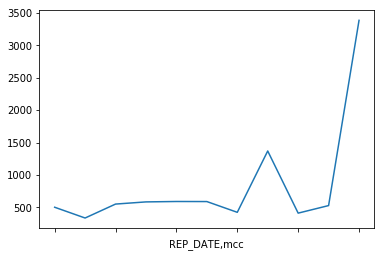

In [142]:
# Generate stat report by country

mcc = 310

df3=df1[df1.index.get_level_values('mcc')==mcc].sort_index(level=['mcc','REP_DATE'])
print(df3,'\n')

df3['charge'].plot()
plt.show()

### By operator

In [143]:
# Find out the operator with the biggest increase

df1=df.groupby(['REP_DATE','mcc','mnc']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
df1['quantity']=round(df1['quantity'],1)
df1['charge']=round(df1['charge'],1)
df1['cost']=round(df1['cost'],1)

df2=df1.groupby(level=['mcc','mnc']).agg({'charge':[np.sum,'min','mean','max','std']}).copy()

# Two options of sorting

df2.apply(f,axis=1).sort_values(by=[('charge','sum'),'std_per'],ascending=False).head()
df2.apply(f,axis=1).sort_values(by=['diff','std_per'],ascending=False).head()

charge                                          std_per    diff
             sum     min         mean     max         std                
mcc mnc                                                                  
310 680   9291.0   337.9   844.636364  3386.1  885.983471   104.9  3048.2
655 1    17313.1  1007.9  1573.918182  2512.7  543.366968    34.5  1504.8
620 2    11383.6   297.0  1034.872727  1584.9  385.323490    37.2  1287.9
262 2     5616.7   111.0   510.609091   842.2  240.793440    47.2   731.2
250 20    1324.3     0.3   132.430000   720.9  231.926483   175.1   720.6

                    quantity    cost  charge
REP_DATE   mcc mnc                          
2018-05-04 310 680   26155.6   322.5   503.9
2018-05-05 310 680   18581.9   218.3   337.9
2018-05-06 310 680   29786.2   353.7   552.8
2018-05-07 310 680   31855.7   382.1   586.3
2018-05-08 310 680   31136.7   401.2   592.6
2018-05-09 310 680   31944.4   378.8   591.6
2018-05-10 310 680   23702.9   296.9   425.7
2018-05-11 310 680   24281.5   839.6  1371.3
2018-05-12 310 680   18071.8   275.8   413.1
2018-05-13 310 680   27513.2   332.1   529.7
2018-05-14 310 680   24313.9  1995.4  3386.1 



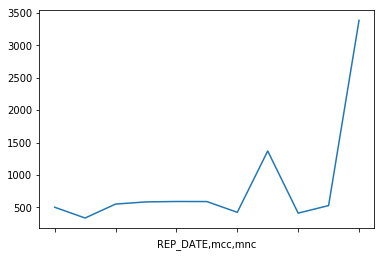

In [144]:
# Generate stat report by country

mcc = 310
mnc = 680

df3=df1[(df1.index.get_level_values('mcc')==mcc) & (df1.index.get_level_values('mnc')==mnc)]\
      .sort_index(level=['mnc','REP_DATE'])
print(df3,'\n')

df3['charge'].plot()
plt.show()

### By customer

In [147]:
# Find out the customer with the biggest increase

df1=df.groupby(['REP_DATE','mcc','mnc','account_id']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
df1['quantity']=round(df1['quantity'],1)
df1['charge']=round(df1['charge'],1)
df1['cost']=round(df1['cost'],1)

df2=df1.groupby(level=['mcc','mnc','account_id']).agg({'charge':[np.sum,'min','mean','max','std']}).copy()

# Two options of sorting

#df2.apply(f,axis=1).sort_values(by=[('charge','sum'),'std_per'],ascending=False).head()
df2.apply(f,axis=1).sort_values(by=['diff','std_per'],ascending=False).head()

charge                                        std_per  \
                       sum    min        mean     max         std           
mcc mnc account_id                                                          
310 680 352342      8658.8  297.4  787.163636  3337.1  887.261741   112.7   
655 1   352345      8562.0  497.9  778.363636  1248.1  266.698093    34.3   
        352366      8562.0  497.9  778.363636  1248.1  266.698093    34.3   
250 20  352342      1196.4    0.3  119.640000   720.9  230.298083   192.5   
620 2   352345      5625.2  148.5  511.381818   782.0  189.760901    37.1   

                      diff  
                            
mcc mnc account_id          
310 680 352342      3039.7  
655 1   352345       750.2  
        352366       750.2  
250 20  352342       720.6  
620 2   352345       633.5

                               quantity    cost  charge
REP_DATE   mcc mnc account_id                          
2018-05-04 310 680 352342       22616.3   263.3   454.6
2018-05-05 310 680 352342       15513.6   171.6   297.4
2018-05-06 310 680 352342       25982.0   290.3   502.7
2018-05-07 310 680 352342       26774.1   300.2   519.8
2018-05-08 310 680 352342       27427.3   316.2   543.9
2018-05-09 310 680 352342       27656.7   310.4   537.4
2018-05-10 310 680 352342       17786.0   198.0   342.9
2018-05-11 310 680 352342       18892.5   750.4  1296.0
2018-05-12 310 680 352342       12698.8   197.6   342.1
2018-05-13 310 680 352342       24086.5   279.7   484.9
2018-05-14 310 680 352342       20484.0  1933.8  3337.1 



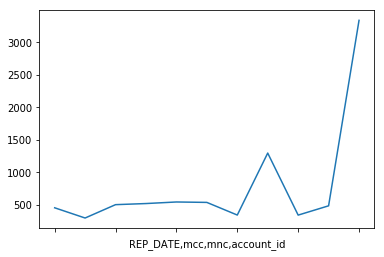

In [148]:
# Generate stat report by country

mcc = 310
mnc = 680
account_id = 352342

df3=df1[(df1.index.get_level_values('mcc')==mcc) & (df1.index.get_level_values('mnc')==mnc) & (df1.index.get_level_values('account_id')==account_id)]\
      .sort_index(level=['mnc','REP_DATE'])
print(df3,'\n')

df3['charge'].plot()
plt.show()